<a href="https://colab.research.google.com/github/yxmauw/cxr-multilabel-clf/blob/main/enet-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up environment

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/yxmauw/cxr-multilabel-clf.git

Cloning into 'cxr-multilabel-clf'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 63 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [3]:
!mkdir ~/.kaggle #Make a directory named “.kaggle”

In [4]:
!cp ./cxr-multilabel-clf//kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory

In [5]:
!chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file

In [6]:
!kaggle competitions download -c ranzcr-clip-catheter-line-classification # download dataset

100% 11.7G/11.7G [06:38<00:00, 38.3MB/s]
100% 11.7G/11.7G [06:38<00:00, 31.5MB/s]


In [ ]:
!unzip ranzcr-clip-catheter-line-classification.zip #unzip folders

## Data

In [8]:
import numpy as np 
import pandas as pd 

In [9]:
train_df = pd.read_csv('train.csv')
display(len(train_df))
display(train_df.head(3))
train_annot_df = pd.read_csv('train_annotations.csv')
display(len(train_annot_df))
display(train_annot_df.head(3))

30083

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5


17999

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."


In [10]:
# value counts
train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum'])
# unbalanced dataset

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
sum,79,1138,7240,279,529,2748,4797,3195,8460,21324,830


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

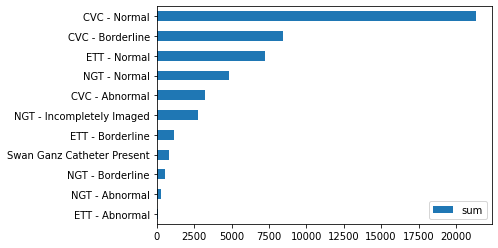

In [12]:
# value counts
train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum']).T.sort_values(by='sum').plot(kind='barh')
plt.legend(loc='lower right');

In [ ]:
len(train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum']).T)
# num of classes

11

## Create Datasets

In [11]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

In [12]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['StudyInstanceUID']
        self.all_labels = np.array(self.csv.drop(['StudyInstanceUID', 'PatientID'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"./train/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [13]:
import torchvision
torchvision.__version__

'0.13.1+cu113'

In [ ]:
print(dir(torchvision.models))

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_Weights', 'RegNet_X_3_2GF_Weig

In [14]:
from torchvision import models 
import torch.nn as nn

In [19]:
def model(pretrained, requires_grad):
    model = models.efficientnet_v2_s(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 11 classes in total
    model.classifier[1] = nn.Linear(in_features=1280, out_features=11)
    return model

In [15]:
!pip install torchmetrics 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 14.3 MB/s 


## Create Train and Validate functions

In [16]:
from tqdm import tqdm
from torchmetrics import Accuracy, AUROC, F1Score, Precision, Recall

In [20]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    # instantiate metrics
    acc = Accuracy()
    auc = AUROC()
    f1_score = F1Score()
    precision = Precision()
    recall = Recall()
    preds = []
    labels = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        labels.append(target.cpu().numpy().argmax(axis=1))
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        preds.append(outputs.detach().cpu().numpy().argmax(axis=1))
        
    train_loss = train_running_loss / counter
    preds = torch.tensor(np.concatenate(preds))
    labels = torch.tensor(np.concatenate(labels))
    train_acc = acc(preds, labels).item()
    
    return train_loss, train_acc

In [21]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    # instantiate metrics
    acc = Accuracy()
    auc = AUROC()
    f1_score = F1Score()
    precision = Precision()
    recall = Recall()
    preds = []
    labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            labels.append(target.cpu().numpy().argmax(axis=1))
            # make predictions
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            preds.append(outputs.detach().cpu().numpy().argmax(axis=1))
        
        val_loss = val_running_loss / counter
        preds = torch.tensor(np.concatenate(preds))
        labels = torch.tensor(np.concatenate(labels))
        val_acc = acc(preds, labels).item()
        return val_loss, val_acc

In [22]:
import torch.optim as optim
import matplotlib
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set model parameters

In [23]:
#intialize the model
from torch.optim.lr_scheduler import ReduceLROnPlateau

ENet_model = model(pretrained=False, requires_grad=True).to(device)
# learning parameters
lr = 0.0001
epochs = 25
batch_size = 4
optimizer = optim.Adam(ENet_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.BCELoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [24]:
train_data = ImageDataset(
    train_df, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_df, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 25570
Number of validation images: 4513


## Create save model class function

In [26]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            file_path = f'drive/MyDrive/Colab Notebooks/Enet-ep{epoch+1}-val{current_valid_loss:.3f}.pth'
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, file_path)

## Save plots

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('drive/MyDrive/Colab Notebooks/Enet-acc.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('drive/MyDrive/Colab Notebooks/Enet-loss.png')

## Create earlystopper class function

In [27]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Train model

In [ ]:
# start the training and validation
train_loss = []
valid_loss = []
train_acc = []
val_acc = []
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
save_best_model = SaveBestModel() # initialize SaveBestModel class
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        ENet_model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, val_epoch_acc = validate(
        ENet_model, valid_loader, criterion, valid_data, device
    )
    if early_stopper.early_stop(valid_epoch_loss):             
        break
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_acc.append(val_epoch_acc)
    print(f'Train Loss: {train_epoch_loss:.4f}; Val Loss: {valid_epoch_loss:.4f}; Train accuracy: {train_epoch_acc:.4f}; Val accuracy: {val_epoch_acc:.4f}')
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, ENet_model, optimizer, criterion
    )
    print('='*50) # gap

save_plots(train_acc, val_acc, train_loss, valid_loss)
print('PLOTS SAVED')

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Epoch 1 of 30
Training


  0%|          | 0/6392 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
6393it [55:18,  1.93it/s]


Validating


1126it [07:01,  2.67it/s]


Train Loss: 0.2887; Val Loss: 0.2701; Train accuracy: 0.4308; Val accuracy: 0.4373

Best validation loss: 0.27008894395552985

Saving best model for epoch: 1

Epoch 2 of 30
Training


6393it [53:15,  2.00it/s]


Validating


1126it [07:03,  2.66it/s]


Train Loss: 0.2763; Val Loss: 0.2648; Train accuracy: 0.4333; Val accuracy: 0.4895

Best validation loss: 0.26484752869891864

Saving best model for epoch: 2

Epoch 3 of 30
Training


6393it [53:31,  1.99it/s]


Validating


1126it [07:03,  2.66it/s]


Train Loss: 0.2719; Val Loss: 0.2589; Train accuracy: 0.4349; Val accuracy: 0.4317

Best validation loss: 0.2588627720268222

Saving best model for epoch: 3

Epoch 4 of 30
Training


6393it [53:18,  2.00it/s]


Validating


1126it [07:02,  2.67it/s]


Train Loss: 0.2665; Val Loss: 0.2580; Train accuracy: 0.4372; Val accuracy: 0.4666

Best validation loss: 0.257986861266209

Saving best model for epoch: 4

Epoch 5 of 30
Training


6393it [53:13,  2.00it/s]


Validating


1126it [07:05,  2.65it/s]


Train Loss: 0.2613; Val Loss: 0.2500; Train accuracy: 0.4460; Val accuracy: 0.4610

Best validation loss: 0.25000611321461347

Saving best model for epoch: 5

Epoch 6 of 30
Training


6393it [53:29,  1.99it/s]


Validating


1126it [07:08,  2.63it/s]


Train Loss: 0.2523; Val Loss: 0.2343; Train accuracy: 0.4856; Val accuracy: 0.6040

Best validation loss: 0.2342516876571873

Saving best model for epoch: 6

Epoch 7 of 30
Training


6393it [53:23,  2.00it/s]


Validating


1126it [07:05,  2.65it/s]


Train Loss: 0.2431; Val Loss: 0.2315; Train accuracy: 0.5421; Val accuracy: 0.6249

Best validation loss: 0.23147968413907088

Saving best model for epoch: 7

Epoch 8 of 30
Training


6393it [54:42,  1.95it/s]


Validating


1126it [07:03,  2.66it/s]


Train Loss: 0.2374; Val Loss: 0.2245; Train accuracy: 0.5726; Val accuracy: 0.6251

Best validation loss: 0.2244645284842799

Saving best model for epoch: 8

Epoch 9 of 30
Training


6393it [53:26,  1.99it/s]


Validating


1126it [07:01,  2.67it/s]


Train Loss: 0.2351; Val Loss: 0.2245; Train accuracy: 0.5784; Val accuracy: 0.6018
Epoch 10 of 30
Training


6393it [53:15,  2.00it/s]


Validating


1126it [07:00,  2.68it/s]


Train Loss: 0.2323; Val Loss: 0.2268; Train accuracy: 0.5925; Val accuracy: 0.5412
Epoch 11 of 30
Training


6393it [53:03,  2.01it/s]


Validating


1126it [07:02,  2.66it/s]


Train Loss: 0.2302; Val Loss: 0.2227; Train accuracy: 0.5969; Val accuracy: 0.6171

Best validation loss: 0.2226692042768425

Saving best model for epoch: 11

Epoch 12 of 30
Training


6393it [53:38,  1.99it/s]


Validating


1126it [07:11,  2.61it/s]


Train Loss: 0.2288; Val Loss: 0.2232; Train accuracy: 0.6007; Val accuracy: 0.5976
Epoch 13 of 30
Training


6393it [53:04,  2.01it/s]


Validating


1126it [07:08,  2.63it/s]


Train Loss: 0.2271; Val Loss: 0.2196; Train accuracy: 0.5988; Val accuracy: 0.6154

Best validation loss: 0.2195812863749361

Saving best model for epoch: 13

Epoch 14 of 30
Training


6393it [53:41,  1.98it/s]


Validating


1126it [07:08,  2.63it/s]


Train Loss: 0.2255; Val Loss: 0.2187; Train accuracy: 0.6017; Val accuracy: 0.6258

Best validation loss: 0.21869684002803866

Saving best model for epoch: 14

Epoch 15 of 30
Training


6393it [53:47,  1.98it/s]


Validating


1126it [07:12,  2.60it/s]


Train Loss: 0.2238; Val Loss: 0.2193; Train accuracy: 0.6014; Val accuracy: 0.6023
Epoch 16 of 30
Training


6393it [53:57,  1.97it/s]


Validating


1126it [07:09,  2.62it/s]


Train Loss: 0.2225; Val Loss: 0.2148; Train accuracy: 0.5998; Val accuracy: 0.5952

Best validation loss: 0.21480766724510578

Saving best model for epoch: 16

Epoch 17 of 30
Training


6393it [54:16,  1.96it/s]


Validating


1126it [07:11,  2.61it/s]


Train Loss: 0.2210; Val Loss: 0.2136; Train accuracy: 0.6009; Val accuracy: 0.6060

Best validation loss: 0.2136137347509605

Saving best model for epoch: 17

Epoch 18 of 30
Training


6393it [53:49,  1.98it/s]


Validating


1126it [07:06,  2.64it/s]


Train Loss: 0.2186; Val Loss: 0.2118; Train accuracy: 0.6012; Val accuracy: 0.6040

Best validation loss: 0.21180420065196115

Saving best model for epoch: 18

Epoch 19 of 30
Training


6393it [54:20,  1.96it/s]


Validating


1126it [07:10,  2.61it/s]


Train Loss: 0.2173; Val Loss: 0.2099; Train accuracy: 0.6003; Val accuracy: 0.5958

Best validation loss: 0.20991460148569321

Saving best model for epoch: 19

Epoch 20 of 30
Training


 57%|█████▋    | 3646/6392 [30:30<23:46,  1.92it/s]

## Evaluate model

In [17]:
model_path = 'drive/MyDrive/Colab Notebooks/Enet-ep19-val0.210.pth'

In [20]:
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#intialize the model
test_model = model(pretrained=False, requires_grad=False).to(device)
# load the model checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
# load model weights state_dict
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [23]:
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_df, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

In [24]:
# get the list of label names from train_df
tube_statuses = train_df.columns.values[1:12]

## Run a Loop to Get the Predictions
We will iterate over the test data loader and get the predictions for 1 batch (10 images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


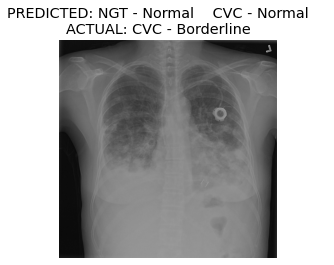

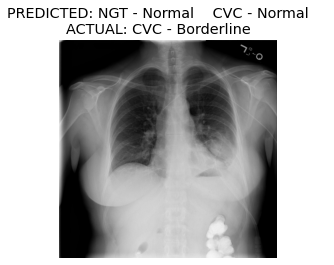

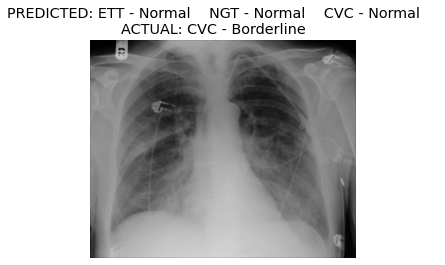

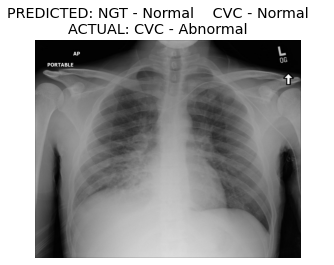

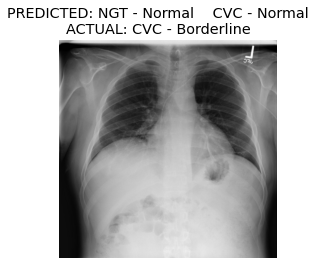

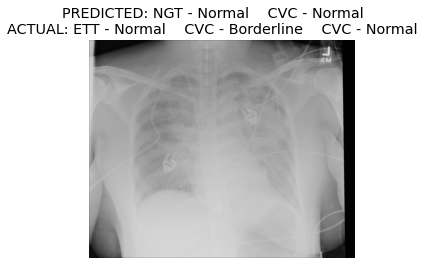

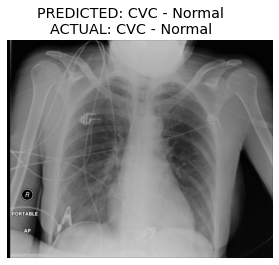

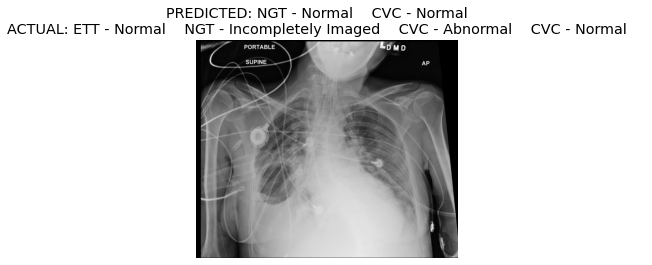

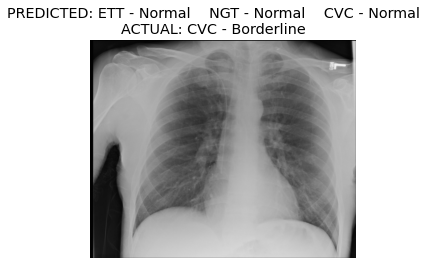

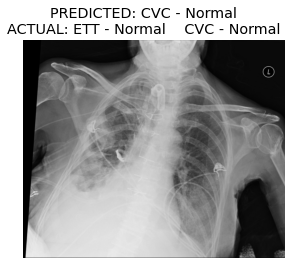

In [26]:
def preds_preview():
    for counter, data in enumerate(test_loader):
        image, target = data['image'].to(device), data['label']
        # get all the index positions where value == 1
        target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
        # get the predictions by passing the image through the model
        outputs = test_model(image) # predictions
        outputs = torch.sigmoid(outputs)
        outputs = outputs.detach().cpu()
        prob_indices = torch.flatten(np.argwhere(outputs[0]>0.4)) # adjust probability threshold here, need flatten to convert 2d to 1d 
        # print(prob_indices) # 1d list of indices e.g. 6 to correspond to label
        string_predicted = ''
        string_actual = ''
        for i in range(len(prob_indices)):
            string_predicted += f"{tube_statuses[prob_indices[i]]}    " #string concat
        for i in range(len(target_indices)):
            string_actual += f"{tube_statuses[target_indices[i]]}    "
        image = image.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        # plt.savefig(f"drive/MyDrive/Colab Notebooks/inferences/inference_{counter}.jpg")
        plt.show()
        
preds_preview()

Should output 10 images for inference using test dataset. 

Looks like the model consistently output 3 labels under ETT, NGT and CVC even though not all 3 categories are labelled for every image. 

## Construct Kaggle submission file

__Reference:__
1. [Kaggle notebook](https://www.kaggle.com/code/ammarali32/resnet200d-inference-single-model-lb-96-5)

In [27]:
test2_models = [test_model.to(device)] # make model become an iterable

In [28]:
TEST_PATH = 'test' # define for following class function

In [29]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [30]:
import albumentations
from albumentations import *
from albumentations.pytorch import ToTensorV2

In [31]:
def get_transforms():
        return Compose([
            Resize(400, 400),
            Normalize(
            ),
            ToTensorV2(),
        ])

In [48]:
def inference(models, test_loader, device):
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for model in models:
            with torch.no_grad():
                y_preds1 = model(images)
                #y_preds2 = model(images.flip(-1)) # vertical flip 
            #y_preds = (y_preds1.sigmoid().to('cpu').numpy() + y_preds2.sigmoid().to('cpu').numpy()) / 2
            y_preds = y_preds1.sigmoid().to('cpu').numpy()
            avg_preds.append(y_preds)
        avg_preds = np.mean(avg_preds, axis=0) # 2d nested prob arrays for each batch of 4 images
        # best to convert preds using 0.4 threshold conversion to binary classes before appending using if-else statment
        new_avg_preds = []
        for prob_arr in avg_preds:
            label_arr = [1 if prob >= 0.4 else 0 for prob in prob_arr] # threshold 0.4 probability
            new_avg_preds.append(label_arr)
        probs.append(new_avg_preds) 
    probs = np.concatenate(probs)
    return probs

In [49]:
test = pd.read_csv('sample_submission.csv')

In [50]:
test_dataset = TestDataset(test, transform=get_transforms())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, 
                         num_workers=4 , pin_memory=True)
predictions = inference(test2_models, test_loader, device)

100%|██████████| 896/896 [11:43<00:00,  1.27it/s]


In [52]:
target_cols = test.iloc[:, 1:12].columns.tolist()
test[target_cols] = predictions
test[['StudyInstanceUID'] + target_cols].to_csv('drive/MyDrive/Colab Notebooks/kaggle_submission.csv', index=False)
test.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,1,0,0,0,0,0,0,1,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,1,0,0,0,0,0,1,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,1,0,0,1,0,0,1,1,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,1,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,1,0,0,1,0,0,1,0,0
